# A simple benchmark example

In [1]:
from plumed_bench_pp.parser import parse_full_benchmark_output
from plumed_bench_pp.tabulate import convert_to_table
from plumed_bench_pp.plot import plot_histo
import plumed_bench_pp.constants as plmdbppconst
import plumed_bench_pp.utils as plmdbpputils
import matplotlib.pyplot as plt
import numpy as np
nthreads=[1,2,4,6,8,10,12]

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

The benchmark are run with the following plumed.dat file:

```plumed
cpu: COORDINATION GROUPA=@mdatoms R_0=1

PRINT ARG=* FILE=Colvar FMT=%8.4f STRIDE=1

FLUSH STRIDE=1

```

and we use the following script for the running the benchmark:
```bash
export PLUMED_MAXBACKUP=0
for nt in 1 2 4 6 8 10 12; do
    export PLUMED_NUM_THREADS=$nt
    for nat in 100 500 1000; do
        plumed benchmark --nsteps=500 --natoms=$nat --atom-distribution=sc > "./run/sc_${nt}_${nat}.out"
    done
done
```

Text(0, 0.5, 'time (s)')

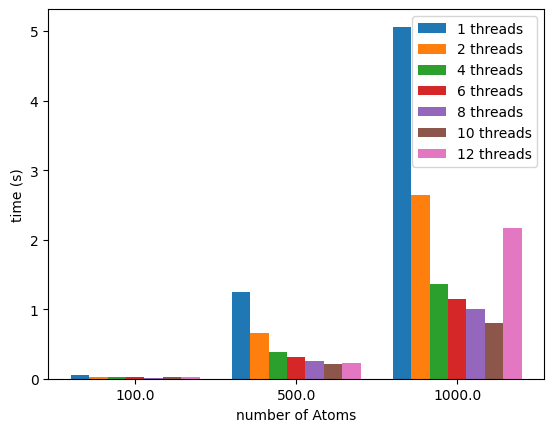

In [2]:
#bash script to prepare the data to be plotted
!for threads in 1 2 4 6 8 10 12; do \
    { for natoms in 100 500 1000; do \
        echo -n "$natoms ";\
        fname="./run/sc_${threads}_${natoms}.out";\
        sed -n '/PLUMED: *Cycles *Total *Average *Minimum *Maximum/{n ; p}' "${fname}" | \
        awk '{printf "%f ", $3}';\
        echo "";\
        done;\
    } > "./run/times_${threads}.out";\
done

simPerThread={}
for threads in nthreads:
    simPerThread[threads]=np.loadtxt(f"./run/times_{threads}.out")
fig,ax =plt.subplots()

ncols = len(simPerThread)
x = simPerThread[nthreads[0]][:,0]
x_coord=np.arange(len(x))
width = 0.8/ncols
ax.set_xticks(x_coord + width * 0.5 * (ncols - 1), x)

for multiplier, nt in enumerate(nthreads):
    offset = width * multiplier

    toplot = simPerThread[nt][:,1]
    ax.bar(
            x_coord + offset,
            toplot,
            width,
            label=f"{nt} threads",
        )
       
ax.legend()
ax.set_xlabel("number of Atoms")
ax.set_ylabel("time (s)")

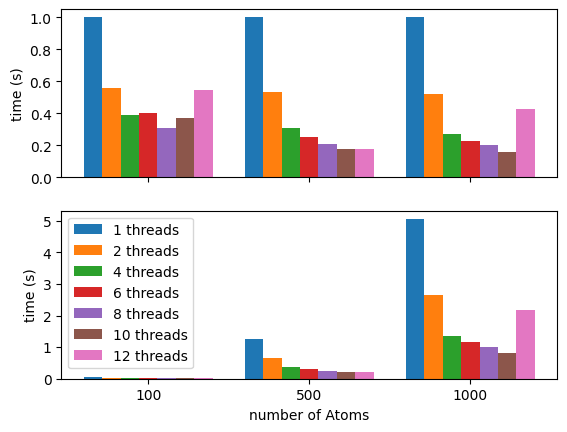

In [3]:
benchmarks={}

for threads in nthreads:
    benchmarks[threads]=[]
    for atoms in [100, 500, 1000]:
        with open(f"./run/sc_{threads}_{atoms}.out") as f:
            benchmarks[threads].append(parse_full_benchmark_output(f.readlines()))

t=[]
for threads in nthreads:
    t.append(convert_to_table(benchmarks[threads],kernel="this",inputlist=".dat",rows_to_extract=[plmdbppconst.TOTALTIME]))
fig,axes =plt.subplots(2,1,sharex=True)
plot_histo(axes[0],t,plmdbppconst.TOTALTIME, titles=[f"{threads} threads" for threads in nthreads],relative_to=0)
plot_histo(axes[1],t,plmdbppconst.TOTALTIME, titles=[f"{threads} threads" for threads in nthreads])

axes[1].set_xlabel("number of Atoms")
axes[1].legend()
for ax in axes:
    ax.set_ylabel("time (s)")


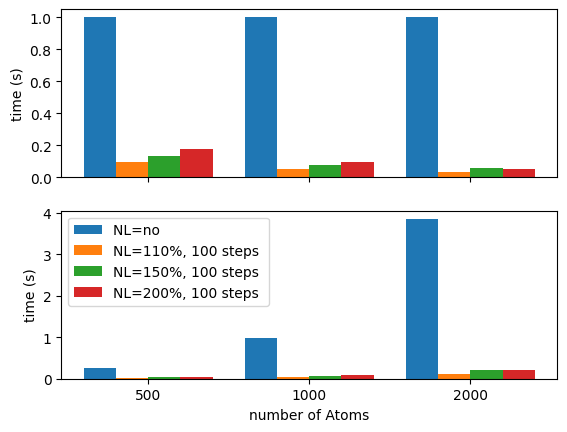

In [4]:
benchmarks=[]

for atoms in [500, 1000, 2000]:
    with open(f"./run/sc_NL_{atoms}.out") as f:
        benchmarks.append(parse_full_benchmark_output(f.readlines()))

t=[]

for input in ["plumed.dat",  "plumedNL110.dat",  "plumedNL150.dat",  "plumedNL200.dat"]:
    t.append(convert_to_table(benchmarks,kernel="this",inputlist=input,rows_to_extract=[plmdbppconst.TOTALTIME]))

NL=["no", "110%, 100 steps" , "150%, 100 steps", "200%, 100 steps"]
fig,axes =plt.subplots(2,1,sharex=True)
plot_histo(axes[0],t,plmdbppconst.TOTALTIME, titles=[f"NL={nl} " for nl in NL],relative_to=0)
plot_histo(axes[1],t,plmdbppconst.TOTALTIME, titles=[f"NL={nl} " for nl in NL])

axes[1].set_xlabel("number of Atoms")
axes[1].legend()
for ax in axes:
     ax.set_ylabel("time (s)")


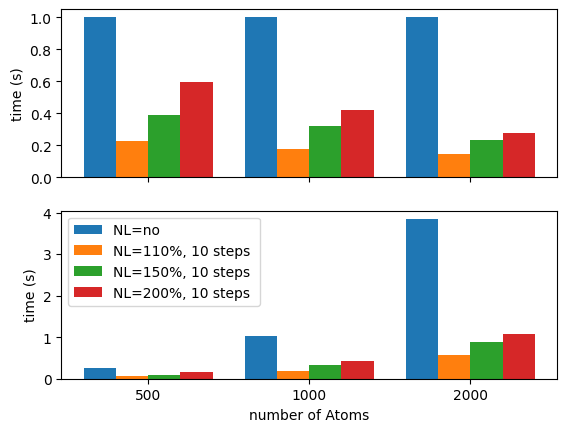

In [5]:
benchmarks=[]

for atoms in [500, 1000, 2000]:
    with open(f"./run/sc_NL_shortstride_{atoms}.out") as f:
        benchmarks.append(parse_full_benchmark_output(f.readlines()))

t=[]
NL=["no", "110%, 10 steps" , "150%, 10 steps", "200%, 10 steps"]
for input in ["plumed.dat",  "plumedNL110_shortstride.dat",  "plumedNL150_shortstride.dat",  "plumedNL200_shortstride.dat"]:
    t.append(convert_to_table(benchmarks,kernel="this",inputlist=input,rows_to_extract=[plmdbppconst.TOTALTIME]))

fig,axes =plt.subplots(2,1,sharex=True)
plot_histo(axes[0],t,plmdbppconst.TOTALTIME, titles=[f"NL={nl} " for nl in NL],relative_to=0)
plot_histo(axes[1],t,plmdbppconst.TOTALTIME, titles=[f"NL={nl} " for nl in NL])

axes[1].set_xlabel("number of Atoms")
axes[1].legend()
for ax in axes:
     ax.set_ylabel("time (s)")

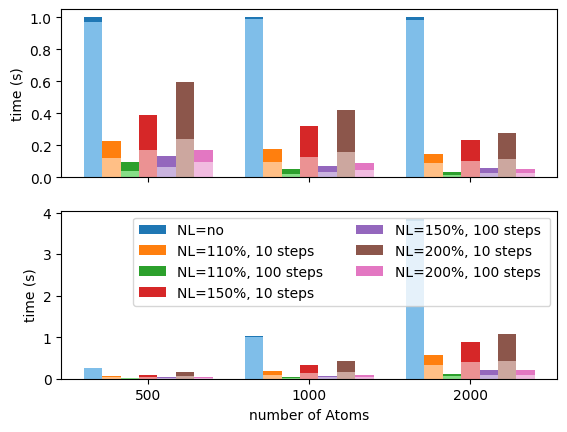

In [6]:
benchmarks100=[]
benchmarks10=[]

for atoms in [500, 1000, 2000]:
    with open(f"./run/sc_NL_shortstride_{atoms}.out") as f:
        benchmarks10.append(parse_full_benchmark_output(f.readlines()))
    with open(f"./run/sc_NL_{atoms}.out") as f:
        benchmarks100.append(parse_full_benchmark_output(f.readlines()))

t=[]
rows_to_extract=[plmdbppconst.TOTALTIME,plmdbppconst.CALCULATE]
t.append(convert_to_table(benchmarks10,kernel="this",inputlist="plumed.dat",rows_to_extract=rows_to_extract))
NL=["no","110%, 10 steps" , "110%, 100 steps", "150%, 10 steps", "150%, 100 steps", "200%, 10 steps", "200%, 100 steps"]
for perc in [110, 150, 200]:
    t.append(convert_to_table(benchmarks10,kernel="this",inputlist=f"plumedNL{perc}_shortstride.dat",rows_to_extract=rows_to_extract))
    t.append(convert_to_table(benchmarks100,kernel="this",inputlist=f"plumedNL{perc}.dat",rows_to_extract=rows_to_extract))
colors=[f"C{i}" for i in range(len(t))]
lc=[lighten_color(c) for c in colors]
fig,axes =plt.subplots(2,1,sharex=True)
plot_histo(axes[0],t,plmdbppconst.TOTALTIME, titles=[f"NL={nl} " for nl in NL],relative_to=0,colors=colors) 
plot_histo(axes[0],t,plmdbppconst.CALCULATE, relative_to=0, relative_to_row=plmdbppconst.TOTALTIME,colors=lc) 
plot_histo(axes[1],t,plmdbppconst.TOTALTIME, titles=[f"NL={nl} " for nl in NL],colors=colors)
plot_histo(axes[1],t,plmdbppconst.CALCULATE, colors=lc)

axes[1].set_xlabel("number of Atoms")
axes[1].legend(ncols=2)
for ax in axes:
     ax.set_ylabel("time (s)")
#here the lighter color is the time spent in calculate()

Text(0, 0.5, 'time/(time no NL)')

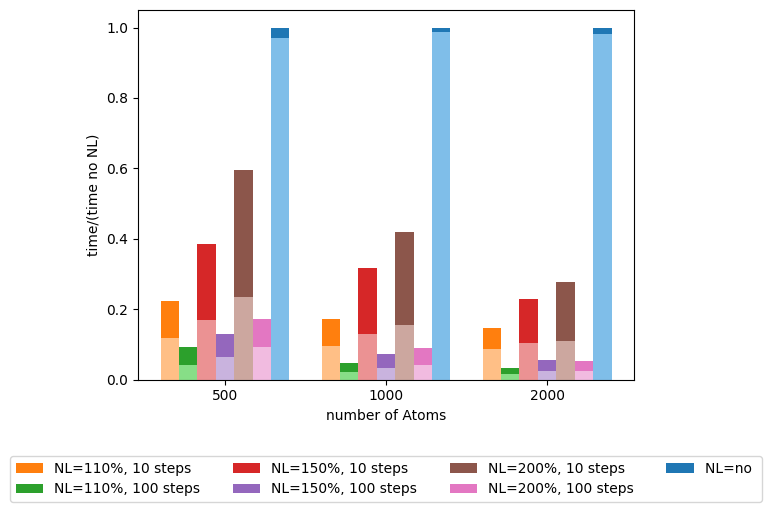

In [8]:
benchmarks100=[]
benchmarks10=[]

for atoms in [500, 1000, 2000]:
    with open(f"./run/sc_NL_shortstride_{atoms}.out") as f:
        benchmarks10.append(parse_full_benchmark_output(f.readlines()))
    with open(f"./run/sc_NL_{atoms}.out") as f:
        benchmarks100.append(parse_full_benchmark_output(f.readlines()))

t=[]
rows_to_extract=[plmdbppconst.TOTALTIME,plmdbppconst.CALCULATE]

NL=["110%, 10 steps" , "110%, 100 steps", "150%, 10 steps", "150%, 100 steps", "200%, 10 steps", "200%, 100 steps","no"]
for perc in [110, 150, 200]:
    t.append(convert_to_table(benchmarks10,kernel="this",inputlist=f"plumedNL{perc}_shortstride.dat",rows_to_extract=rows_to_extract))
    t.append(convert_to_table(benchmarks100,kernel="this",inputlist=f"plumedNL{perc}.dat",rows_to_extract=rows_to_extract))
t.append(convert_to_table(benchmarks10,kernel="this",inputlist="plumed.dat",rows_to_extract=rows_to_extract))
colors=[f"C{i}" for i in range(1,len(t))]+["C0"]
lc=[lighten_color(c) for c in colors]
fig,ax =plt.subplots()
plot_histo(ax,t,plmdbppconst.TOTALTIME, titles=[f"NL={nl} " for nl in NL],relative_to=-1,colors=colors) 
plot_histo(ax,t,plmdbppconst.CALCULATE, relative_to=-1, relative_to_row=plmdbppconst.TOTALTIME,colors=lc) 



ax.set_xlabel("number of Atoms")
ax.legend(ncols=4,loc="lower center", bbox_to_anchor=(0.5, -0.35))
ax.set_ylabel("time/(time no NL)")